In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm
import matplotlib.pyplot as plt
%matplotlib inline


%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ="all"

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('data/World_Bank_mobile_data.csv')
gdp = pd.read_csv('data/GDP_data.csv')

### Clean ATM Data

In [3]:
#Rename Columns
df.rename(columns = {"Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+) [FX.OWN.TOTL.MA.ZS]": "Males_15plus", 
                       "Account ownership at a financial institution or with a mobile-money-service provider, poorest 40% (% of population ages 15+) [FX.OWN.TOTL.40.ZS]": "poorest40perc_15plus", 
                       "Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+) [FX.OWN.TOTL.ZS]": "pop_15plus",
                       "Account ownership at a financial institution or with a mobile-money-service provider, richest 60% (% of population ages 15+) [FX.OWN.TOTL.60.ZS]":"richest60perc_15plus",
                       "Automated teller machines (ATMs) (per 100,000 adults) [FB.ATM.TOTL.P5]":"ATM_per100K",  
                        "Account ownership at a financial institution or with a mobile-money-service provider, young adults (% of population ages 15-24) [FX.OWN.TOTL.YG.ZS]": "young_adults_15-24",
                        "Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+) [FX.OWN.TOTL.FE.ZS]": "Females_15plus",
                        "Account ownership at a financial institution or with a mobile-money-service provider, older adults (% of population ages 25+) [FX.OWN.TOTL.OL.ZS]": "older_adults_25plus",
                        "Account ownership at a financial institution or with a mobile-money-service provider, primary education or less (% of population ages 15+) [FX.OWN.TOTL.PL.ZS]": "primaryed_or_less",
                        "Account ownership at a financial institution or with a mobile-money-service provider, secondary education or more (% of population ages 15+) [FX.OWN.TOTL.SO.ZS]": "secondaryed_or_more",
                        "Mobile cellular subscriptions [IT.CEL.SETS]": "mobile_subscr",
                        "Mobile cellular subscriptions (per 100 people) [IT.CEL.SETS.P2]": "mobile_subscr_per100K",
                        "Country Name":"Country",
                        "Time": "Year"},
                        inplace=True)

#drop null
df = df.drop(['Time Code'], axis=1)
df = df.drop([13203, 13204]) #drop strings in the Year Column
df = df.replace(to_replace = '..', value=np.nan, regex=False) #replace all the blank values with nan
df.dropna(subset=['Year', 'ATM_per100K', 'mobile_subscr_per100K'], inplace = True)
#ATM_Per100 = 3350 rows --> remove Nan from Mobile --> 2319 rows

#Casting
df['Year'] = df['Year'].astype(int)
cols = df.columns.drop(['Year','Country', 'Country Code'])
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [4]:
#add rate column and drop nulls
df['rate'] = df.sort_values(['Country','Year']).reset_index().groupby('Country')['ATM_per100K'].pct_change()
df['mobile_subscr_per100K'] = df['mobile_subscr_per100K'].apply(lambda x: x*1000)
df = df[['Year', 'Country', 'mobile_subscr_per100K', 'ATM_per100K', 'rate']]

In [5]:
df['ATM_per100K'].describe()

count    3219.000000
mean       41.579199
std        44.309421
min         0.000000
25%         7.689702
50%        30.329917
75%        58.173131
max       324.170505
Name: ATM_per100K, dtype: float64

### Clean GDP Data

In [6]:
#Rename column
gdp.rename(columns = {"Time": "Year",
                    "Country Name":"Country",
                    "GDP per capita (current US$) [NY.GDP.PCAP.CD]": "GDP_percapita",
                    "GDP per capita growth (annual %) [NY.GDP.PCAP.KD.ZG]":"GDP_percapita_growth",
                    "GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]":"GDP_growth_annualperc"
                    },inplace=True)
#drop null
gdp = gdp.drop([13203,13204])
gdp = gdp.drop(['Time Code', 'Country Code'], axis=1)
gdp = gdp.replace(to_replace = '..', value=np.nan, regex=False) #replace all the blank values with nan
gdp.dropna(subset=['Year'], inplace = True)

#casting
gdp['Year'] = gdp['Year'].astype(int)
cols = gdp.columns.drop(['Year', 'Country'])
gdp[cols] = gdp[cols].apply(pd.to_numeric, errors='coerce')
gdp.dropna(subset=['GDP_percapita', 'GDP_percapita_growth', 'GDP_growth_annualperc'], inplace = True)

### Merge Data

In [7]:
#Merge
df = pd.merge(df, gdp, how='left', on=['Country', 'Year']) #2130

In [8]:
df['quantile'] = pd.qcut(df['GDP_percapita'], q=[0, .25, .75, 1], labels=['small', 'medium', 'large'])
df_small = df[df['quantile']=='small']
df_medium = df[df['quantile']=='medium']
df_large = df[df['quantile']=='large']

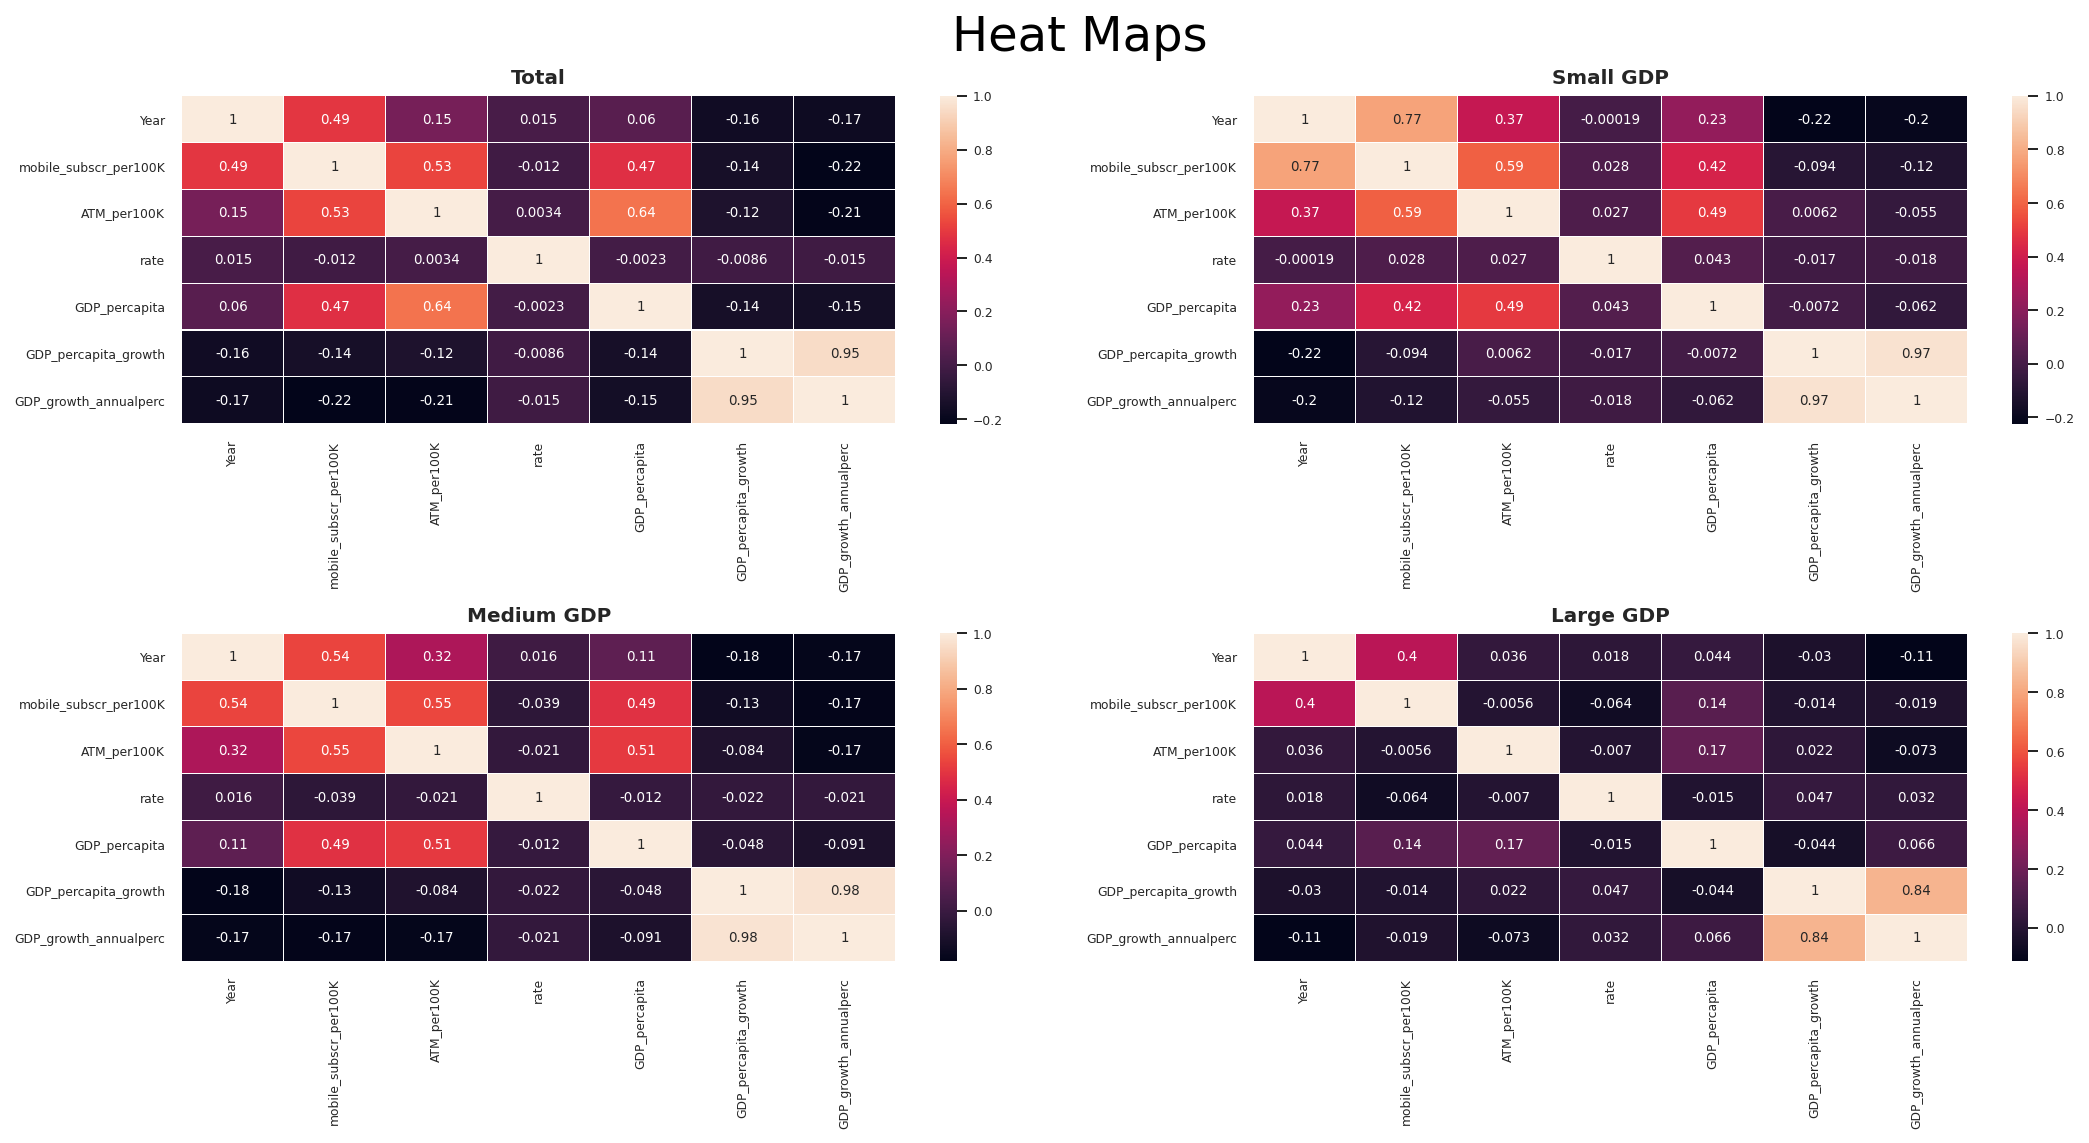

In [9]:
sns.set_context("paper", font_scale = .7, rc={"grid.linewidth": 3})
f = plt.figure(figsize=(15, 8))
_ = f.suptitle('Heat Maps', size=24)
gs = f.add_gridspec(2, 2)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    ax = sns.heatmap(df.corr(), annot = True, linewidths=.05)
    _= ax.set_title('Total', weight='bold', size=10)
    
with sns.axes_style("whitegrid"):
    ax0 = f.add_subplot(gs[0, 1])
    ax0 = sns.heatmap(df_small.corr(), annot = True, linewidths=.05)
    _= ax0.set_title('Small GDP', weight='bold', size=10)
    
with sns.axes_style("darkgrid"):
    ax1 = f.add_subplot(gs[1, 0])
    ax1 = sns.heatmap(df_medium.corr(), annot = True, linewidths=.05)
    _= ax1.set_title('Medium GDP', weight='bold', size=10)

with sns.axes_style("whitegrid"):
    ax2 = f.add_subplot(gs[1, 1])
    ax2 = sns.heatmap(df_large.corr(), annot = True, linewidths=.05)
    _= ax2.set_title('Large GDP', weight='bold', size=10)
    
plt.subplots_adjust(wspace=2,hspace=1)
f.tight_layout()    
_= plt.savefig('Heat_Map')


In [10]:
def best_fit(x, y):
    xbar = sum(x)/len(x)
    ybar = sum(y)/len(y)
    n = len(x) 

    num = sum([xi*yi for xi,yi in zip(x, y)]) - n * xbar * ybar
    den = sum([xi**2 for xi in x]) - n * xbar**2

    b = num / den
    a = ybar - b * xbar

    return a, b

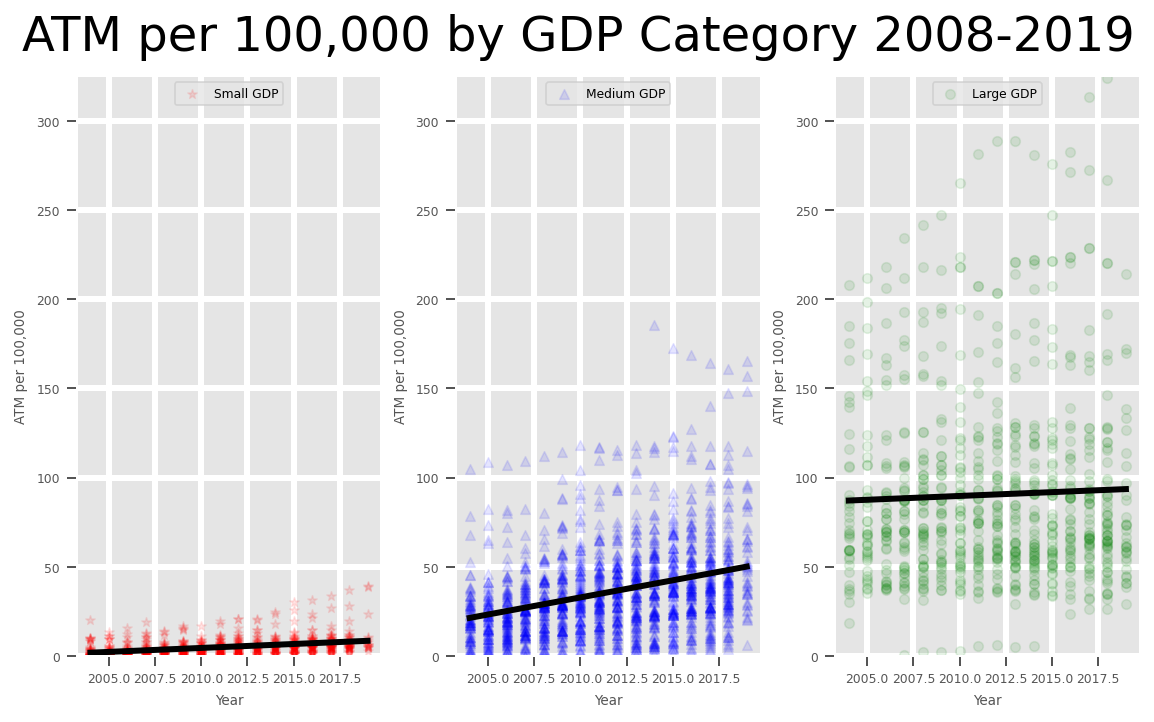

In [11]:
#Scatter ATMs by GDP Total
fig = plt.figure(figsize=(8,5))
_ = fig.suptitle('ATM per 100,000 by GDP Category 2008-2019', size=24)

x0 = df[df['quantile'] == 'small']['Year']
y0 = df[df['quantile'] == 'small']['ATM_per100K']
x1 = df[df['quantile'] == 'medium']['Year']
y1 = df[df['quantile'] == 'medium']['ATM_per100K']
x2 = df[df['quantile'] == 'large']['Year']
y2 = df[df['quantile'] == 'large']['ATM_per100K']

ax1 = fig.add_subplot(1,3,1)
_ = ax1.scatter(x0, y0, marker = '*', alpha = .1, c='red', label="Small GDP" )
_ = ax1.set_ylim([0, 325])
_ = ax1.set_xlabel('Year')
_ = ax1.set_ylabel('ATM per 100,000')
# _ = ax1.set_title('Small GDP')
a, b = best_fit(x0, y0)
yfit0 = [a + b * xi for xi in x0]
_= ax1.plot(x0, yfit0, c='black', lw='3.0')
_= plt.legend(loc='upper center')

ax2 = fig.add_subplot(1,3,2)
_ = ax2.scatter(x1, y1, marker = '^', alpha = .1, c='blue', label="Medium GDP")
_ = ax2.set_ylim([0, 325])
_ = ax2.set_xlabel('Year')
_ = ax2.set_ylabel('ATM per 100,000')
# _ = ax2.set_title('Medium GDP')
a, b = best_fit(x1, y1)
yfit1 = [a + b * xi for xi in x1]
_= ax2.plot(x1, yfit1, c='black', lw='3.0')
_= plt.legend(loc='upper center')


ax3 = fig.add_subplot(1,3,3)
_ = ax3.scatter(x2, y2, marker = 'o', alpha = .1, c='green', label="Large GDP")
_ = ax3.set_ylim([0, 325])
_ = ax3.set_xlabel('Year')
_ = ax3.set_ylabel('ATM per 100,000')
# _ = ax3.set_title('Large GDP')
a, b = best_fit(x2, y2)
yfit2 = [a + b * xi for xi in x2]
_= ax3.plot(x2, yfit2, c='black', lw='3.0')
_= plt.legend(loc='upper center')

plt.subplots_adjust(wspace=0.2,hspace=.4)
plt.tight_layout()
plt.savefig('ATM per 100,000 by GDP Quantile Scatterplot')
plt.show()

### Note: Largest variance in the large GDP countries, and most significant growth in ATM for medium GDP Countries

### Dont use the separate histgrams figures - not helpful.  use the combined ones

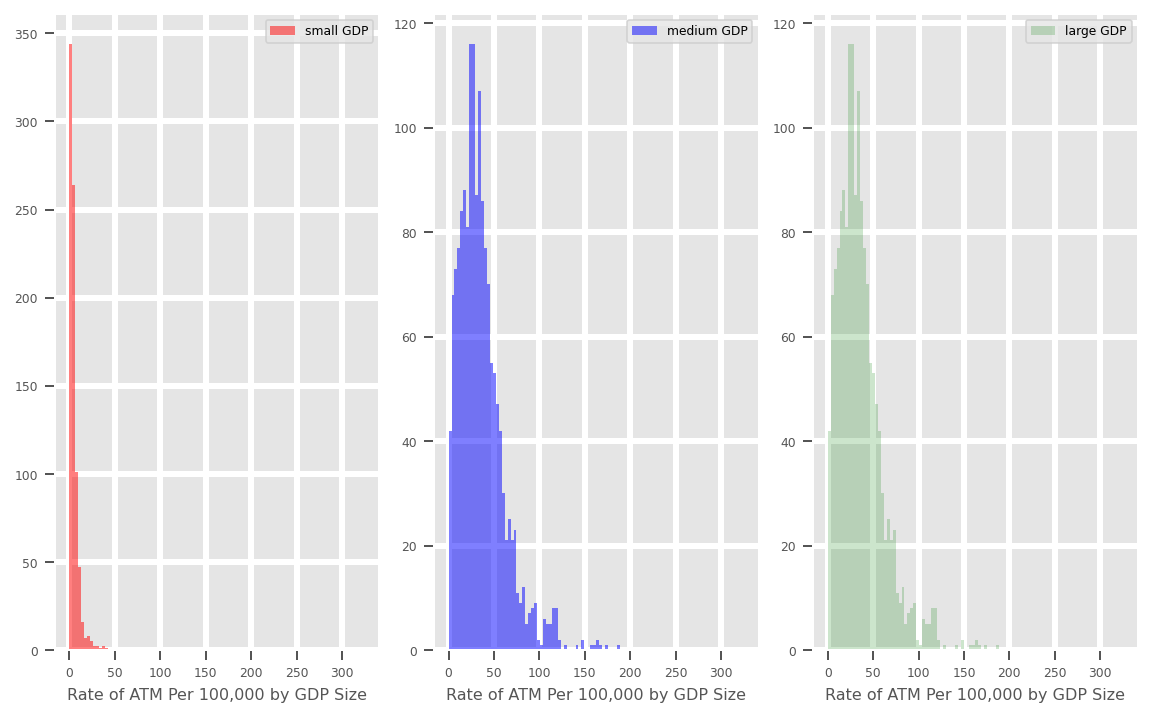

In [12]:
#ATM by GDP Separate Histograms
fig = plt.figure(figsize=(8,5))

y0 = df[df['quantile'] == 'small']['ATM_per100K']
y1 = df[df['quantile'] == 'medium']['ATM_per100K']
y2 = df[df['quantile'] == 'large']['ATM_per100K']

bins = 100
range=[0, 325]

ax1 = fig.add_subplot(1,3,1)
_= ax1.hist(y0, bins, alpha=0.5, range=range, color='red', label='small GDP')
_= plt.xlabel('Rate of ATM Per 100,000 by GDP Size', fontsize=8)
_= plt.legend(loc='upper right')
_= ax2 = fig.add_subplot(1,3,2)
_= ax2.hist(y1, bins, alpha=0.5, range=range, color='blue', label='medium GDP')
_= plt.xlabel('Rate of ATM Per 100,000 by GDP Size', fontsize=8)
_= plt.legend(loc='upper right')
ax3 = fig.add_subplot(1,3,3)
_= ax3.hist(y1, bins, alpha=0.2, range=range, color='green', label='large GDP')
_= plt.xlabel('Rate of ATM Per 100,000 by GDP Size', fontsize=8)
_= plt.legend(loc='upper right')

_= plt.subplots_adjust(wspace=.8,hspace=.8)
_= plt.tight_layout()
# _= plt.savefig('ATM per 100,000 by GDP Quantile Histograms')
_= plt.show()

<ipython-input-13-0163ae32c83c>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()


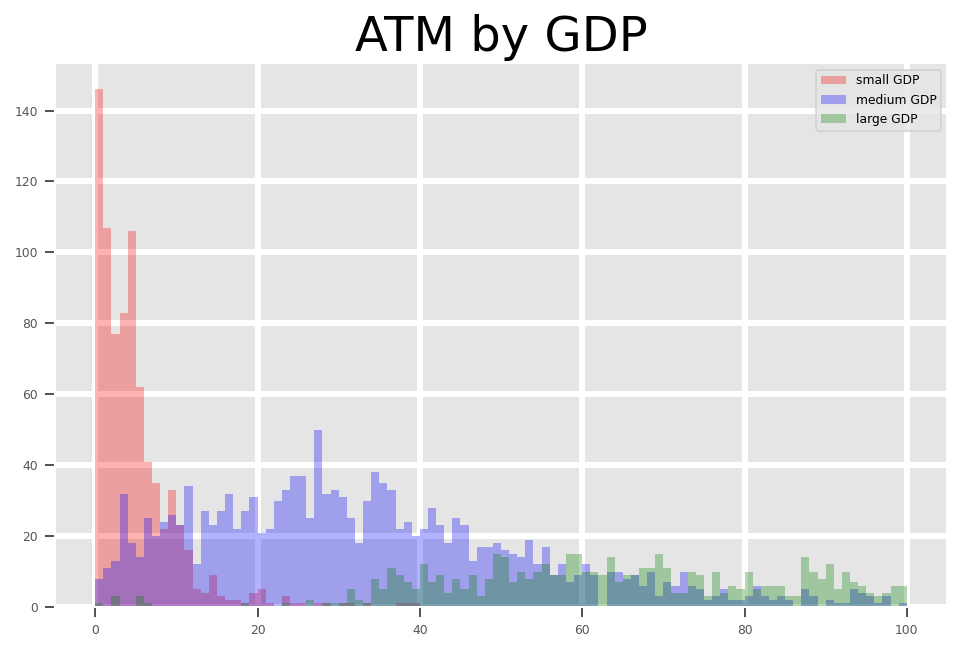

In [13]:
#ATM by GDP Combined Histgram

fig = plt.figure(figsize=(8,5))
_= plt.title('ATM by GDP', size = 24)

y0 = df[df['quantile'] == 'small']['ATM_per100K']
y1 = df[df['quantile'] == 'medium']['ATM_per100K']
y2 = df[df['quantile'] == 'large']['ATM_per100K']

bins = 100
range=[0, 100]

ax = fig.add_subplot()
_= ax.hist(y0, bins, alpha=0.3, range=range, color='red', label='small GDP')
_= ax.hist(y1, bins, alpha=0.3, range=range, color='blue', label='medium GDP')
_= ax.hist(y2, bins, alpha=0.3, range=range, color='green', label='large GDP')
_= plt.legend(loc='upper right')
_= plt.savefig('ATM per 100,000 by GDP Quantile Combined Histogram')


In [14]:
avg = df.groupby(['quantile', 'Year']).mean()
# avg = avg.reset_index(level=[0,1])
avg = df.drop([2,11,22])

### Don't Use This scatter - no helpful information

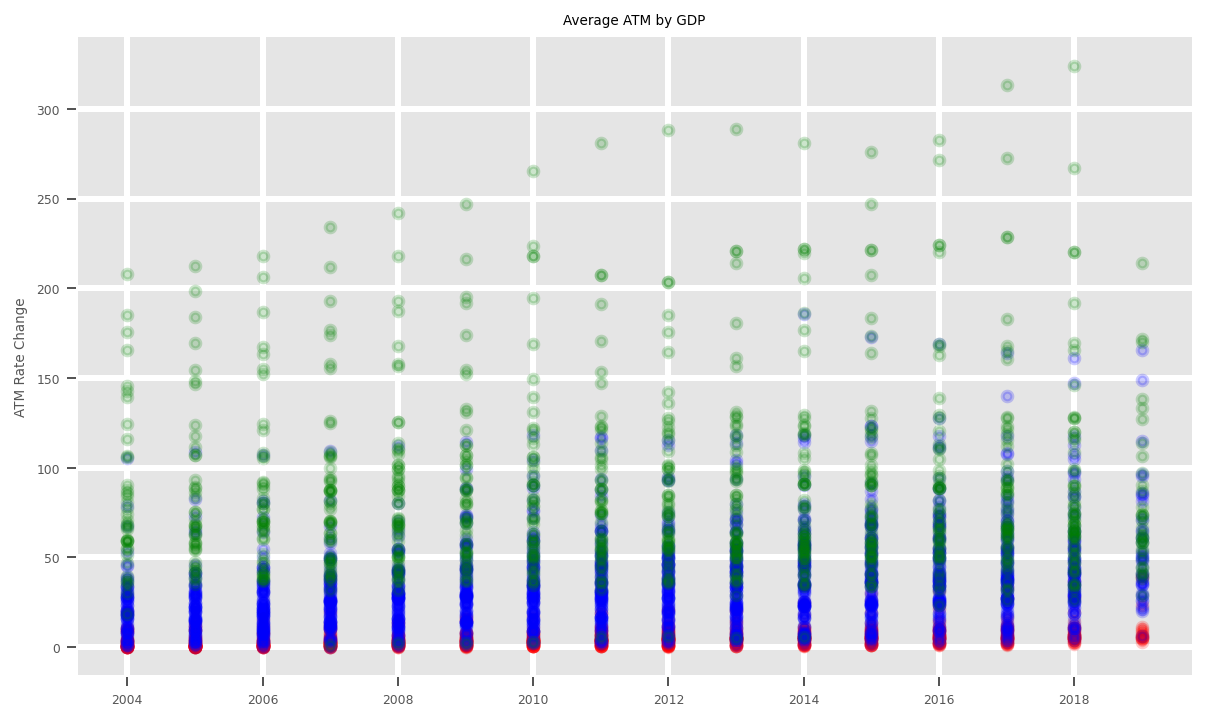

In [15]:
fig = plt.figure(figsize=(10,20))

x0 = avg[avg['quantile'] == 'small']['Year']
y0 = avg[avg['quantile'] == 'small']['ATM_per100K']
x1 = avg[avg['quantile'] == 'medium']['Year']
y1 = avg[avg['quantile'] == 'medium']['ATM_per100K']
x2 = avg[avg['quantile'] == 'large']['Year']
y2 = avg[avg['quantile'] == 'large']['ATM_per100K']

ax1 = fig.add_subplot(3,1,1)
_= ax1.set_ylabel('ATM Rate Change')
_= ax1.set_title('Average ATM by GDP')


small = ax1.scatter(x0, y0, alpha = .2, color='red', lw=2, label='small')
medium = ax1.scatter(x1, y1, alpha = .2, color='blue', lw=2, label='medium')
large = ax1.scatter(x2, y2, alpha = .2, color='green', lw=2, label='large')
ax.legend()
# _= plt.savefig('Average ATM per 100,000 by GDP Quantile Scatter')


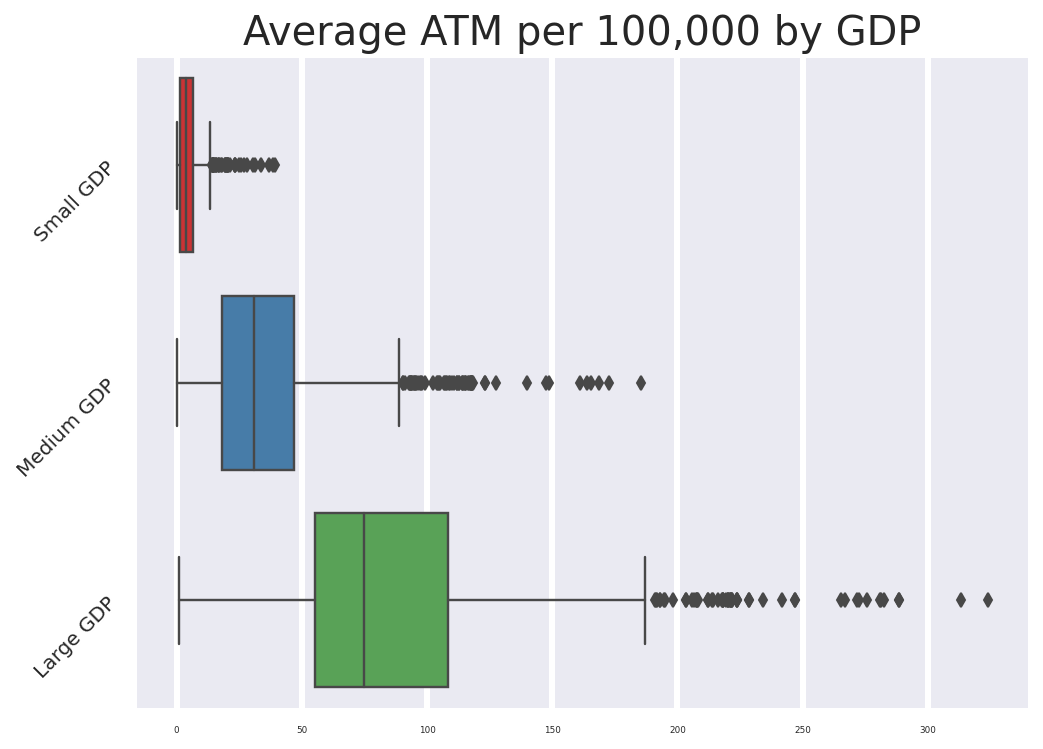

In [16]:

sns.set_theme(style="darkgrid")
sns.set_context("paper", font_scale = .5, rc={"grid.linewidth": 3})

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax = sns.boxplot(data=[y0,y1,y2], orient="h", palette="Set1")
_= ax.set_title('Average ATM per 100,000 by GDP', fontsize=20)
_= ax.set_yticklabels(['Small GDP', 'Medium GDP', 'Large GDP'], rotation=45, fontsize=10)
# sns.boxplot(x=tips[y0,y1,y2])
_= plt.savefig('Average ATM per 100,000 by GDP Quantile BoxPlot')
plt.show()

In [17]:
y0_neg_count = sum(df[df['quantile'] == 'small']['rate'] < 0)
y1_neg_count = sum(df[df['quantile'] == 'medium']['rate'] < 0)
y2_neg_count = sum(df[df['quantile'] == 'large']['rate'] < 0)

print(f'Small GDP with Negative ATM Rate: {y0_neg_count}')         
print(f'Medium GDP with Negative ATM Rate: {y1_neg_count}')  
print(f'Large GDP with Negative ATM Rate: {y2_neg_count} \n')  

y0_pos_count = sum(df[df['quantile'] == 'small']['rate'] > 0)
y1_pos_count = sum(df[df['quantile'] == 'medium']['rate'] > 0)
y2_pos_count = sum(df[df['quantile'] == 'large']['rate'] > 0)

print(f'Small GDP with Positive ATM Rate: {y0_pos_count}')         
print(f'Medium GDP with Positive ATM Rate: {y1_pos_count}')  
print(f'Large GDP with Positive ATM Rate: {y2_pos_count}') 

Small GDP with Negative ATM Rate: 118
Medium GDP with Negative ATM Rate: 233
Large GDP with Negative ATM Rate: 148 

Small GDP with Positive ATM Rate: 381
Medium GDP with Positive ATM Rate: 860
Large GDP with Positive ATM Rate: 390


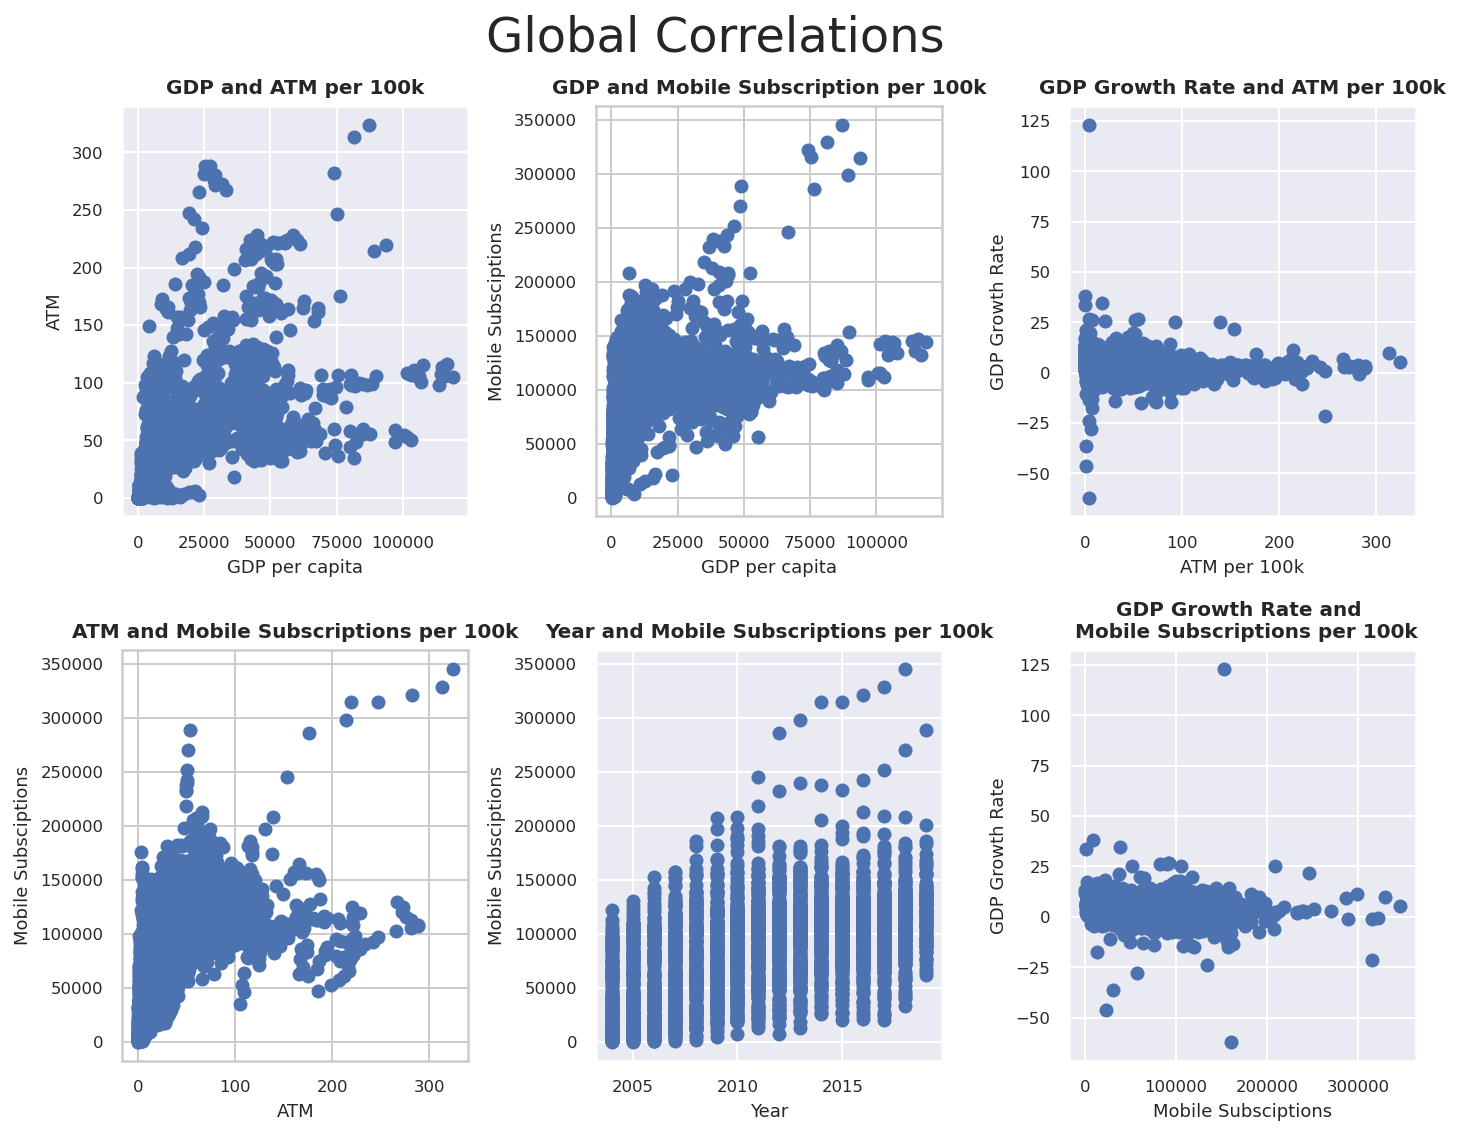

In [18]:
#SNS
sns.set_theme('notebook', font_scale=.75)
f = plt.figure(figsize=(10, 8))
_ = f.suptitle('Global Correlations', size=24)
gs = f.add_gridspec(2, 3)

with sns.axes_style("darkgrid"):
    ax0 = f.add_subplot(gs[0, 0])
    _= plt.scatter(df.GDP_percapita, df.ATM_per100K)
    _= ax0.set_xlabel('GDP per capita')
    _= ax0.set_ylabel('ATM')
    _= ax0.set_title('GDP and ATM per 100k', weight='bold', size=10)

with sns.axes_style("whitegrid"):
    ax1 = f.add_subplot(gs[1, 0])
    _= plt.scatter(df.ATM_per100K, df.mobile_subscr_per100K)
    _= ax1.set_xlabel('ATM')
    _= ax1.set_ylabel('Mobile Subsciptions')
    _= ax1.set_title('ATM and Mobile Subscriptions per 100k', weight='bold', size=10)

with sns.axes_style("whitegrid"):
    ax2 = f.add_subplot(gs[0, 1])
    _= plt.scatter(df.GDP_percapita, df.mobile_subscr_per100K)
    _= ax2.set_xlabel('GDP per capita')
    _= ax2.set_ylabel('Mobile Subsciptions')
    _= ax2.set_title('GDP and Mobile Subscription per 100k', weight='bold', size=10)

with sns.axes_style("darkgrid"):
    ax3 = f.add_subplot(gs[1, 1])
    _= plt.scatter(df.Year, df.mobile_subscr_per100K)
    _= ax3.set_xlabel('Year')
    _= ax3.set_ylabel('Mobile Subsciptions')
    _= ax3.set_title('Year and Mobile Subscriptions per 100k', weight='bold', size=10)
    
with sns.axes_style("darkgrid"):
    ax4 = f.add_subplot(gs[0, 2])
    _= plt.scatter(df.ATM_per100K, df.GDP_growth_annualperc)
    _= ax4.set_xlabel('ATM per 100k')
    _= ax4.set_ylabel('GDP Growth Rate')
    _= ax4.set_title('GDP Growth Rate and ATM per 100k', weight='bold', size=10)

with sns.axes_style("darkgrid"):
    ax5 = f.add_subplot(gs[1, 2])
    _= plt.scatter(df.mobile_subscr_per100K, df.GDP_growth_annualperc)
    _= ax5.set_xlabel('Mobile Subsciptions')
    _= ax5.set_ylabel('GDP Growth Rate')
    _= ax5.set_title('GDP Growth Rate and \n Mobile Subscriptions per 100k', weight='bold', size=10)

plt.subplots_adjust(wspace=1.5,hspace=1)
f.tight_layout()
_= plt.savefig('Global Correlation')

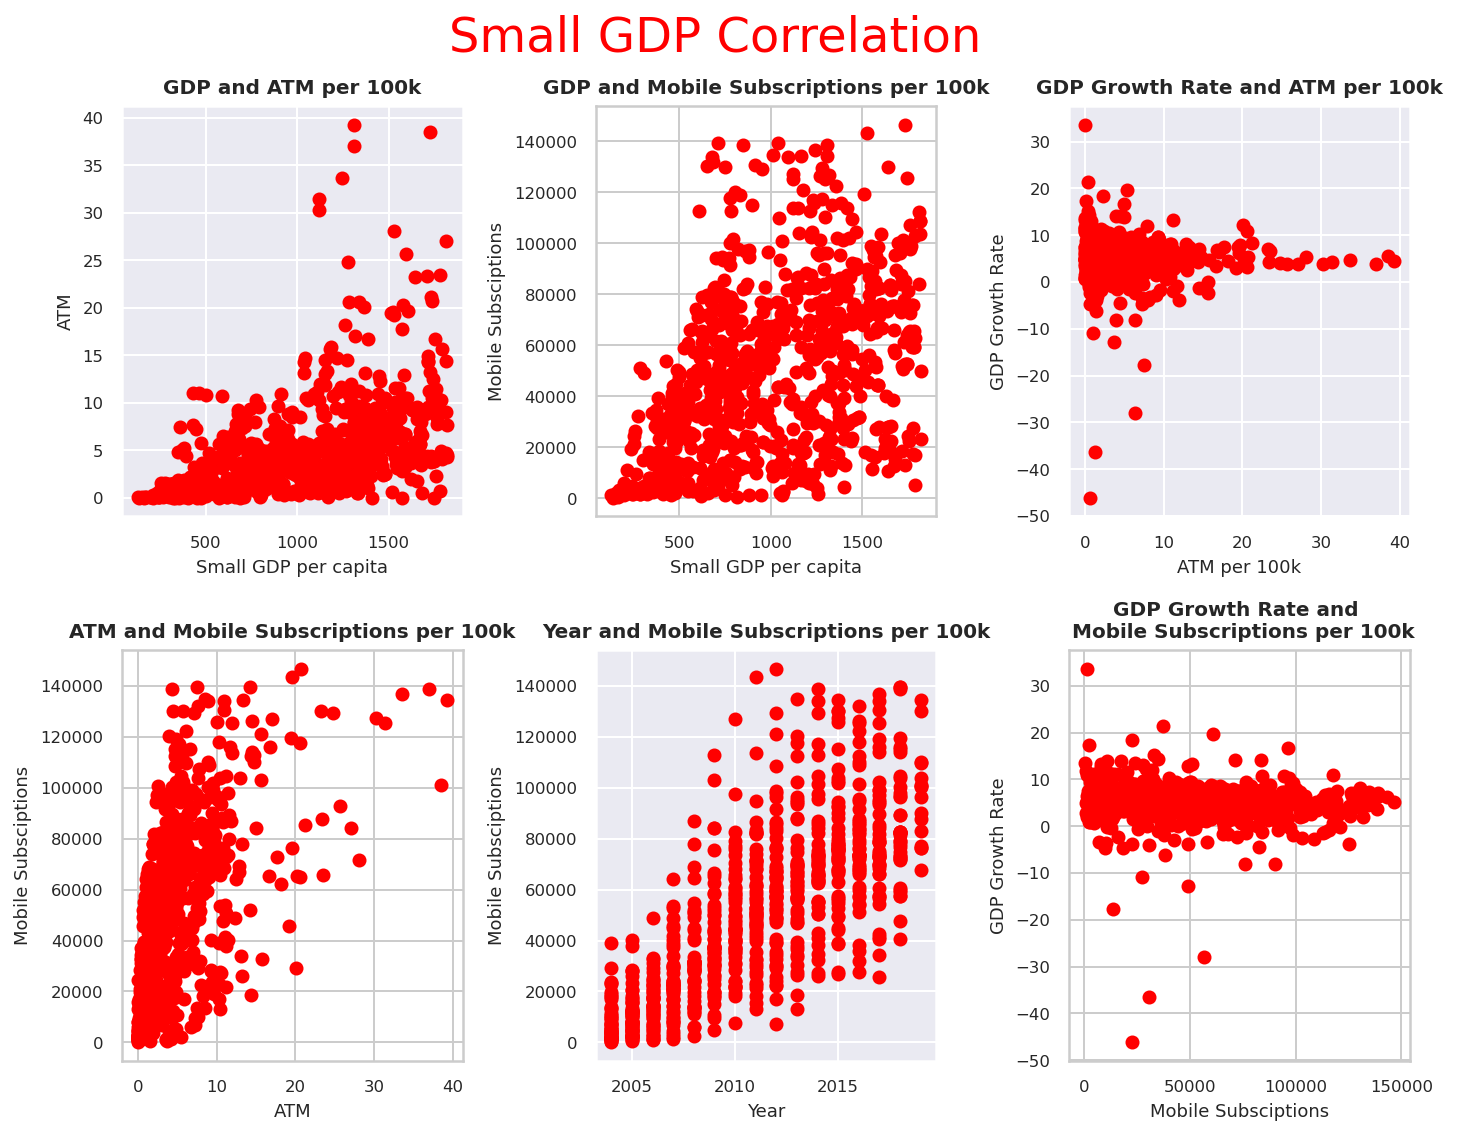

In [19]:
#Small GDP
sns.set_theme('notebook', font_scale=.75)
f = plt.figure(figsize=(10, 8))
_ = f.suptitle('Small GDP Correlation', c = 'red', size=24)
gs = f.add_gridspec(2, 3)

with sns.axes_style("darkgrid"):
    ax0 = f.add_subplot(gs[0, 0])
    _= plt.scatter(df_small.GDP_percapita, df_small.ATM_per100K, c='red')
    _= ax0.set_xlabel('Small GDP per capita')
    _= ax0.set_ylabel('ATM')
    _= ax0.set_title('GDP and ATM per 100k', weight='bold', size=10)

with sns.axes_style("whitegrid"):
    ax1 = f.add_subplot(gs[1, 0])
    _= plt.scatter(df_small.ATM_per100K, df_small.mobile_subscr_per100K, c='red')
    _= ax1.set_xlabel('ATM')
    _= ax1.set_ylabel('Mobile Subsciptions')
    _= ax1.set_title('ATM and Mobile Subscriptions per 100k', weight='bold', size=10)

with sns.axes_style("whitegrid"):
    ax2 = f.add_subplot(gs[0, 1])
    _= plt.scatter(df_small.GDP_percapita, df_small.mobile_subscr_per100K, c='red')
    _= ax2.set_xlabel('Small GDP per capita')
    _= ax2.set_ylabel('Mobile Subsciptions')
    _= ax2.set_title('GDP and Mobile Subscriptions per 100k', weight='bold', size=10)

with sns.axes_style("darkgrid"):
    ax3 = f.add_subplot(gs[1, 1])
    _= plt.scatter(df_small.Year, df_small.mobile_subscr_per100K, c='red')
    _= ax3.set_xlabel('Year')
    _= ax3.set_ylabel('Mobile Subsciptions')
    _= ax3.set_title('Year and Mobile Subscriptions per 100k', weight='bold', size=10)
    
with sns.axes_style("darkgrid"):
    ax4 = f.add_subplot(gs[0, 2])
    _= plt.scatter(df_small.ATM_per100K, df_small.GDP_growth_annualperc, c='red')
    _= ax4.set_xlabel('ATM per 100k')
    _= ax4.set_ylabel('GDP Growth Rate')
    _= ax4.set_title('GDP Growth Rate and ATM per 100k', weight='bold', size=10)

with sns.axes_style("whitegrid"):
    ax5 = f.add_subplot(gs[1, 2])
    _= plt.scatter(df_small.mobile_subscr_per100K, df_small.GDP_growth_annualperc, c='red')
    _= ax5.set_xlabel('Mobile Subsciptions')
    _= ax5.set_ylabel('GDP Growth Rate')
    _= ax5.set_title('GDP Growth Rate and \n Mobile Subscriptions per 100k', weight='bold', size=10)

plt.subplots_adjust(wspace=2,hspace=1)
f.tight_layout()
_= plt.savefig('Small GDP Correlations')

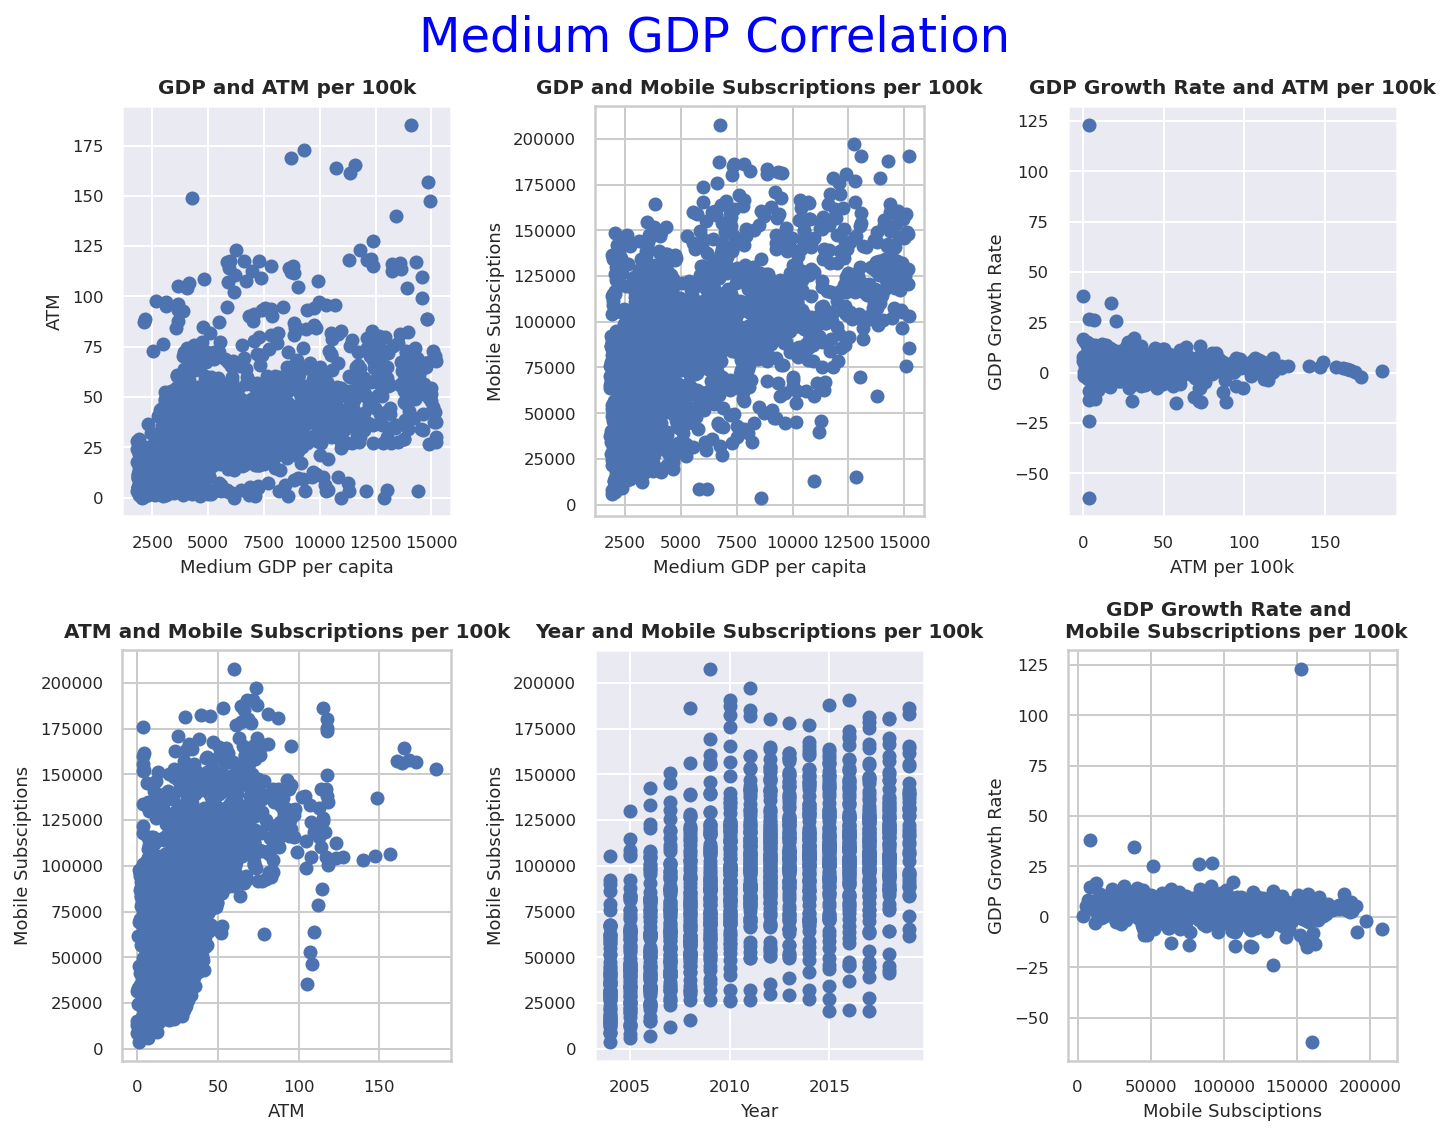

In [20]:
#medium
sns.set_theme('notebook', font_scale=.75)
f = plt.figure(figsize=(10, 8))
_ = f.suptitle('Medium GDP Correlation', c='blue', size=24)
gs = f.add_gridspec(2, 3)

with sns.axes_style("darkgrid"):
    ax0 = f.add_subplot(gs[0, 0])
    _= plt.scatter(df_medium.GDP_percapita, df_medium.ATM_per100K)
    _= ax0.set_xlabel('Medium GDP per capita')
    _= ax0.set_ylabel('ATM')
    _= ax0.set_title('GDP and ATM per 100k', weight='bold', size=10)

with sns.axes_style("whitegrid"):
    ax1 = f.add_subplot(gs[1, 0])
    _= plt.scatter(df_medium.ATM_per100K, df_medium.mobile_subscr_per100K)
    _= ax1.set_xlabel('ATM')
    _= ax1.set_ylabel('Mobile Subsciptions')
    _= ax1.set_title('ATM and Mobile Subscriptions per 100k', weight='bold', size=10)

with sns.axes_style("whitegrid"):
    ax2 = f.add_subplot(gs[0, 1])
    _= plt.scatter(df_medium.GDP_percapita, df_medium.mobile_subscr_per100K)
    _= ax2.set_xlabel('Medium GDP per capita')
    _= ax2.set_ylabel('Mobile Subsciptions')
    _= ax2.set_title('GDP and Mobile Subscriptions per 100k', weight='bold', size=10)

with sns.axes_style("darkgrid"):
    ax3 = f.add_subplot(gs[1, 1])
    _= plt.scatter(df_medium.Year, df_medium.mobile_subscr_per100K)
    _= ax3.set_xlabel('Year')
    _= ax3.set_ylabel('Mobile Subsciptions')
    _= ax3.set_title('Year and Mobile Subscriptions per 100k', weight='bold', size=10)
    
with sns.axes_style("darkgrid"):
    ax4 = f.add_subplot(gs[0, 2])
    _= plt.scatter(df_medium.ATM_per100K, df_medium.GDP_growth_annualperc)
    _= ax4.set_xlabel('ATM per 100k')
    _= ax4.set_ylabel('GDP Growth Rate')
    _= ax4.set_title('GDP Growth Rate and ATM per 100k', weight='bold', size=10)

with sns.axes_style("whitegrid"):
    ax5 = f.add_subplot(gs[1, 2])
    _= plt.scatter(df_medium.mobile_subscr_per100K, df_medium.GDP_growth_annualperc)
    _= ax5.set_xlabel('Mobile Subsciptions')
    _= ax5.set_ylabel('GDP Growth Rate')
    _= ax5.set_title('GDP Growth Rate and \n Mobile Subscriptions per 100k', weight='bold', size=10)

plt.subplots_adjust(wspace=2,hspace=1)
f.tight_layout()
_= plt.savefig('Medium GDP Correlations')

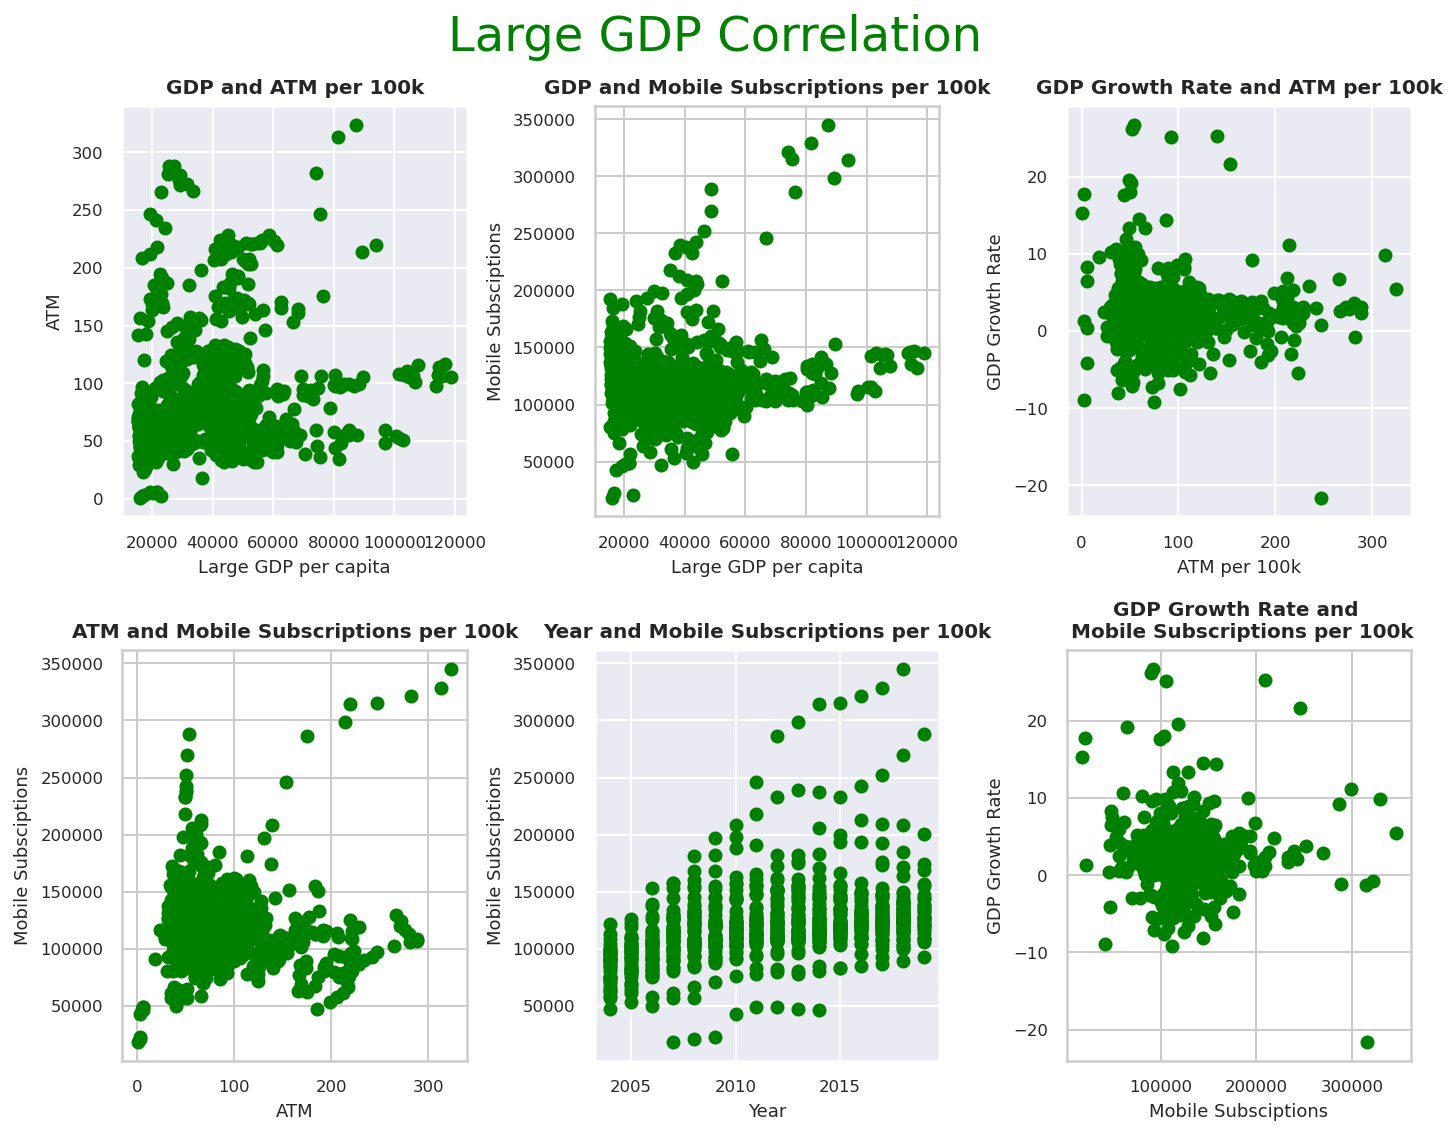

In [21]:
#large
sns.set_theme('notebook', font_scale=.75)
f = plt.figure(figsize=(10, 8))
_ = f.suptitle('Large GDP Correlation', c='green', size=24)
gs = f.add_gridspec(2, 3)

with sns.axes_style("darkgrid"):
    ax0 = f.add_subplot(gs[0, 0])
    _= plt.scatter(df_large.GDP_percapita, df_large.ATM_per100K, c='green')
    _= ax0.set_xlabel('Large GDP per capita')
    _= ax0.set_ylabel('ATM')
    _= ax0.set_title('GDP and ATM per 100k', weight='bold', size=10)

with sns.axes_style("whitegrid"):
    ax1 = f.add_subplot(gs[1, 0])
    _= plt.scatter(df_large.ATM_per100K, df_large.mobile_subscr_per100K, c='green')
    _= ax1.set_xlabel('ATM')
    _= ax1.set_ylabel('Mobile Subsciptions')
    _= ax1.set_title('ATM and Mobile Subscriptions per 100k', weight='bold', size=10)

with sns.axes_style("whitegrid"):
    ax2 = f.add_subplot(gs[0, 1])
    _= plt.scatter(df_large.GDP_percapita, df_large.mobile_subscr_per100K, c='green')
    _= ax2.set_xlabel('Large GDP per capita')
    _= ax2.set_ylabel('Mobile Subsciptions')
    _= ax2.set_title('GDP and Mobile Subscriptions per 100k', weight='bold', size=10)

with sns.axes_style("darkgrid"):
    ax3 = f.add_subplot(gs[1, 1])
    _= plt.scatter(df_large.Year, df_large.mobile_subscr_per100K, c='green')
    _= ax3.set_xlabel('Year')
    _= ax3.set_ylabel('Mobile Subsciptions')
    _= ax3.set_title('Year and Mobile Subscriptions per 100k', weight='bold', size=10)
    
with sns.axes_style("darkgrid"):
    ax4 = f.add_subplot(gs[0, 2])
    _= plt.scatter(df_large.ATM_per100K, df_large.GDP_growth_annualperc, c='green')
    _= ax4.set_xlabel('ATM per 100k')
    _= ax4.set_ylabel('GDP Growth Rate')
    _= ax4.set_title('GDP Growth Rate and ATM per 100k', weight='bold', size=10)

with sns.axes_style("whitegrid"):
    ax5 = f.add_subplot(gs[1, 2])
    _= plt.scatter(df_large.mobile_subscr_per100K, df_large.GDP_growth_annualperc, c='green')
    _= ax5.set_xlabel('Mobile Subsciptions')
    _= ax5.set_ylabel('GDP Growth Rate')
    _= ax5.set_title('GDP Growth Rate and \n Mobile Subscriptions per 100k', weight='bold', size=10)

plt.subplots_adjust(wspace=2,hspace=1)
f.tight_layout()
_= plt.savefig('Large GDP Correlations')

### H0 = GDP does not impact the number of ATMs
### HA = GDP does impact the number of ATMs

In [22]:
def bootstrap_sample_medians(data, n_bootstrap_samples=10**4):
    bootstrap_sample_medians = []
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_sample_medians.append(np.median(bootstrap_sample))
    return bootstrap_sample_medians

In [23]:
def bootstrap_sample_mean(data, n_bootstrap_samples=10**4):
    bootstrap_sample_mean = []
    for i in np.arange(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_sample_mean.append(np.mean(bootstrap_sample))
    return bootstrap_sample_mean

In [24]:
# tstat, pvalue = stats.ttest_ind(small, med)
# tstat, pvalue 
# alpha = 0.05
# print(pvalue < alpha)

### Variance 

In [25]:
y0 = df[df['quantile'] == 'small']['ATM_per100K']
y1 = avg[avg['quantile'] == 'medium']['ATM_per100K']
y2 = avg[avg['quantile'] == 'large']['ATM_per100K']
np.var(y0)
np.var(y1)
np.var(y2)

25.989580468761275

636.9038211042148

2752.84539947577

In [26]:
small = np.array(df_small['ATM_per100K'])
med = np.array(df_medium['ATM_per100K'])
large = np.array(df_large['ATM_per100K'])

In [27]:
df.describe()

,Year,mobile_subscr_per100K,ATM_per100K,rate,GDP_percapita,GDP_percapita_growth,GDP_growth_annualperc
count,3219.000000,3219.000000,3219.000000,2145.000000,3197.000000,3197.000000,3197.000000
mean,2011.462877,88853.627413,41.579199,inf,13164.436732,2.441561,3.877104
std,4.329151,43668.404574,44.309421,NaN,18097.699650,4.695686,4.810665
min,2004.000000,209.503013,0.000000,-0.611212,128.336613,-62.378077,-62.075920
25%,2008.000000,57781.332470,7.689702,0.002857,1819.758841,0.652025,1.936922
50%,2012.000000,93742.067323,30.329917,0.052659,5390.745237,2.476708,3.911693
75%,2015.000000,118127.134050,58.173131,0.149218,15211.576977,4.384897,6.022513
max,2019.000000,345324.522400,324.170505,inf,118823.648369,121.779543,123.139555


In [28]:
df.dropna(inplace=True)

GDP_percapita_growth    7.895481
dtype: float64

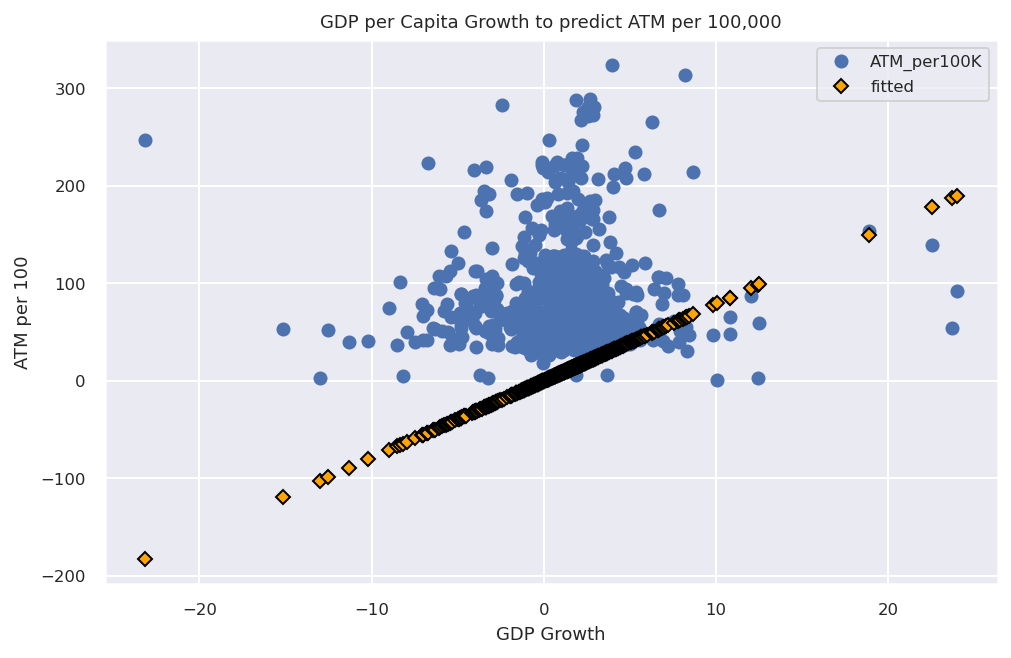

In [39]:
results = sm.OLS(df_large['ATM_per100K'], df_large['GDP_percapita_growth']).fit()
results.params

fig, ax = plt.subplots(figsize=(8,5))
fig = sm.graphics.plot_fit(results, 0, vlines= False, ax=ax, markerfacecolor='orange', markersize=5, markeredgecolor="black")
_= ax.set_ylabel("ATM per 100")
_= ax.set_xlabel("GDP Growth")
_= ax.set_title("GDP per Capita Growth to predict ATM per 100,000")

Intercept                74.329897
GDP_percapita             0.000578
GDP_growth_annualperc    -5.239459
GDP_percapita_growth      5.234624
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ATM_per100K   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     20.66
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           6.71e-13
Time:                        21:31:31   Log-Likelihood:                -4267.9
No. Observations:                 799   AIC:                             8544.
Df Residuals:                     795   BIC:                             8563.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                74.3299      4.149     17.915      0.000      66.186      82.474
GDP_percapita             0.0006   9.48e-05      6.097      0.000       0.000       0.001
GDP_growth_annualperc    -5.2395      0.873     -6.003      0.000      -6.953      -3.526
GDP_percapita_growth      5.2346      0.945      5.540      0.000       3.380       7.089
==============================================================================
Omnibus:                      231.597   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              543.454
Skew:                           1.551   Prob(JB):                    9.78e-119
Kurtosis:                       5.589   Cond. No.                     1.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

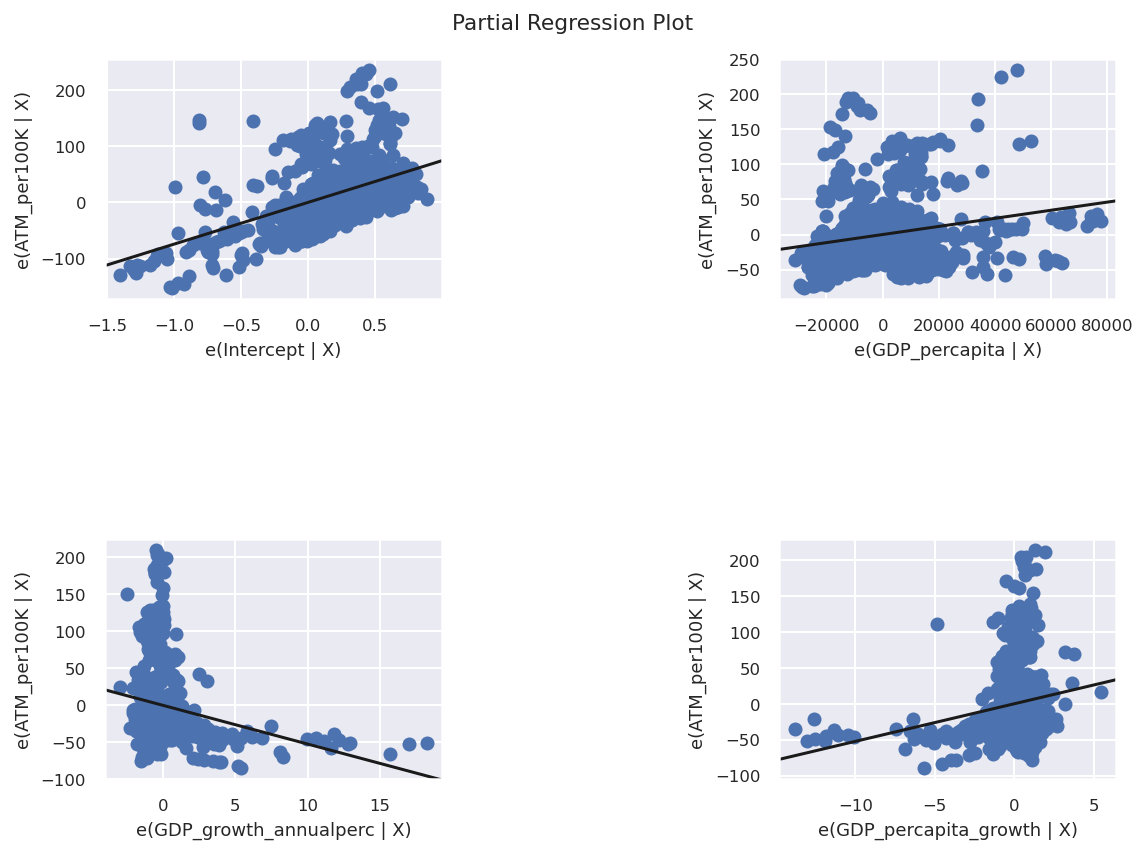

In [30]:
part_regress = sfm.ols(formula="ATM_per100K ~ GDP_percapita + GDP_growth_annualperc + GDP_percapita_growth", data=df_large).fit()
part_regress.params
part_regress.summary()
fig = plt.figure(figsize=(8,6))
fig = sm.graphics.plot_partregress_grid(part_regress, fig=fig)
_= ax.set_ylabel("ATM per 100")
_= ax.set_xlabel("GDP Growth")
_= ax.set_title("Linear Regression")
fig.tight_layout(pad=1)
plt.subplots_adjust(wspace=1,hspace=1)

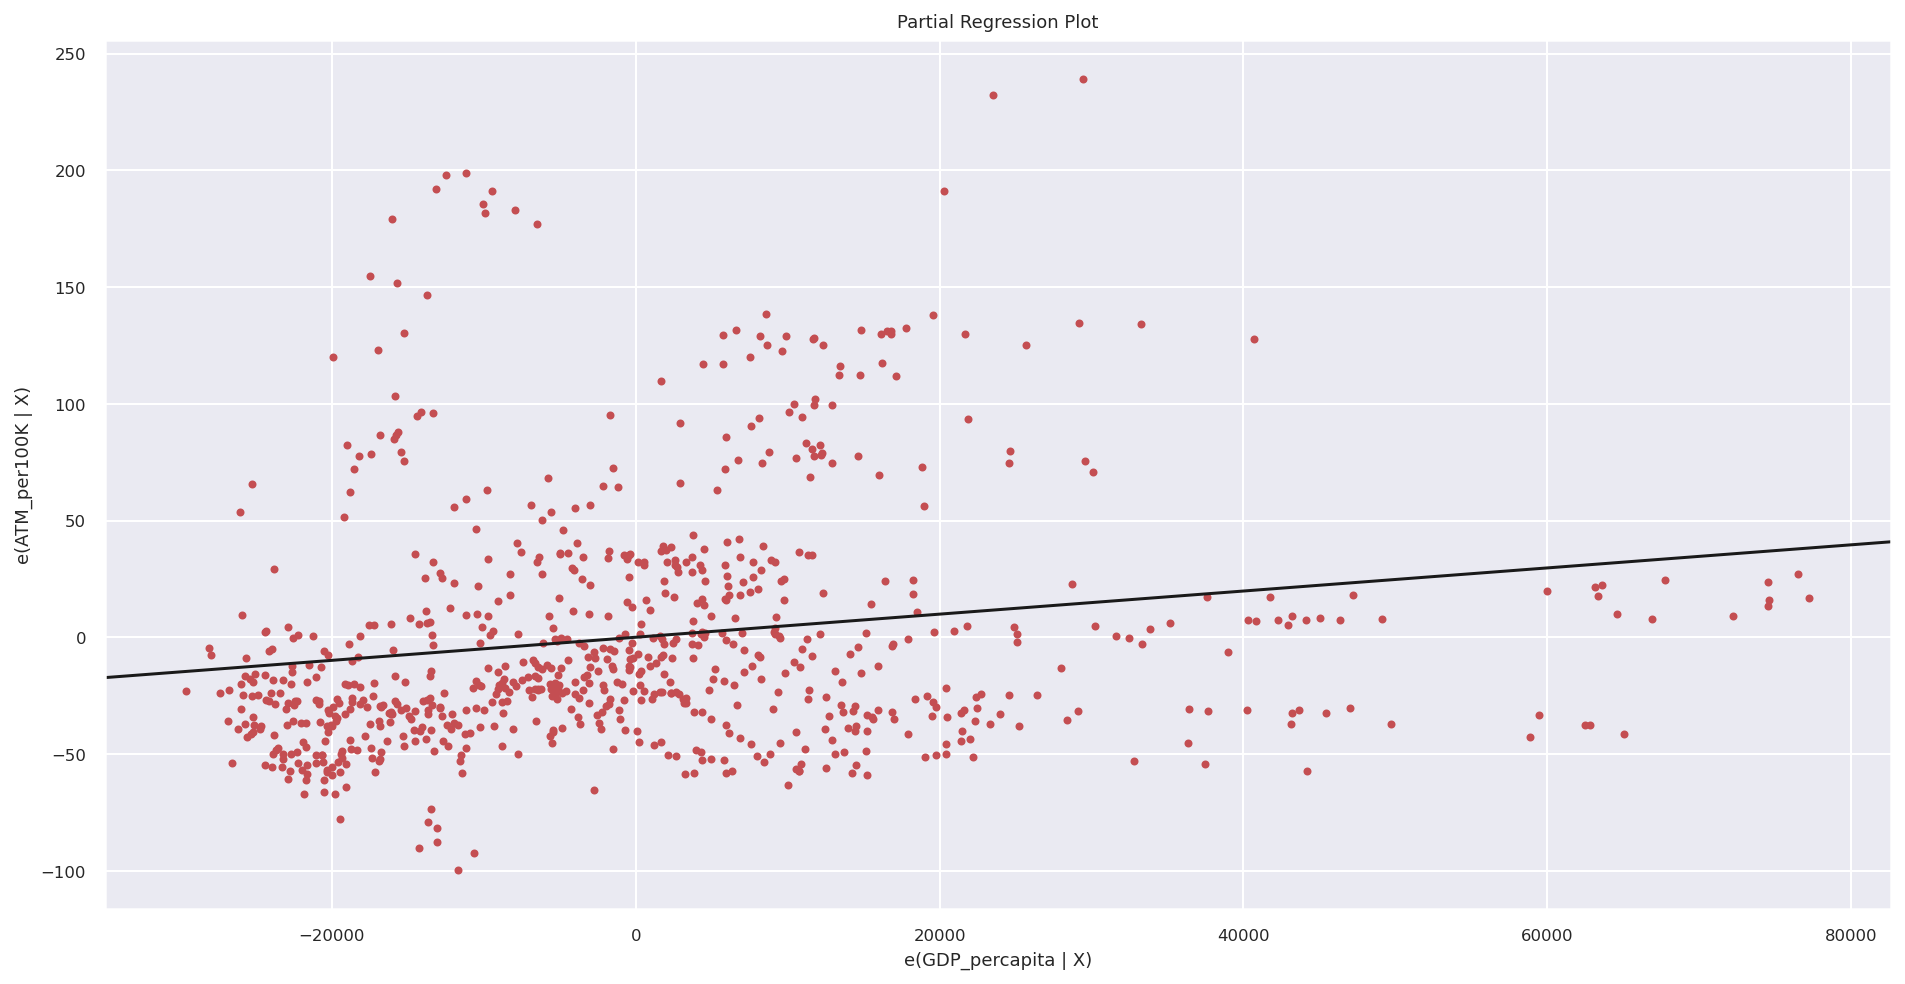

In [31]:
# plt.title('Partial Regression ATM per 100K ~ GDP Per Capita | Mobile Subscription + Annual Growth', size = 24)
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=24)
ax1 = sm.graphics.plot_partregress("ATM_per100K", "GDP_percapita", ['mobile_subscr_per100K', 'GDP_growth_annualperc'], data=df_large, obs_labels=False, marker = '.', c='r')
# ax2 = sm.graphics.plot_partregress("ATM_per100K", "GDP_percapita", ["mobile_subscr_per100K"], data=df_large, obs_labels=False)
# ax3 = sm.graphics.plot_partregress("ATM_per100K", "GDP_percapita", ['GDP_growth_annualperc'] , data=df_large, obs_labels=False)
plt.savefig('Partial Regression Large')
# fig.tight_layout(pad=1.0)

<AxesSubplot:xlabel='GDP_percapita', ylabel='ATM_per100K'>

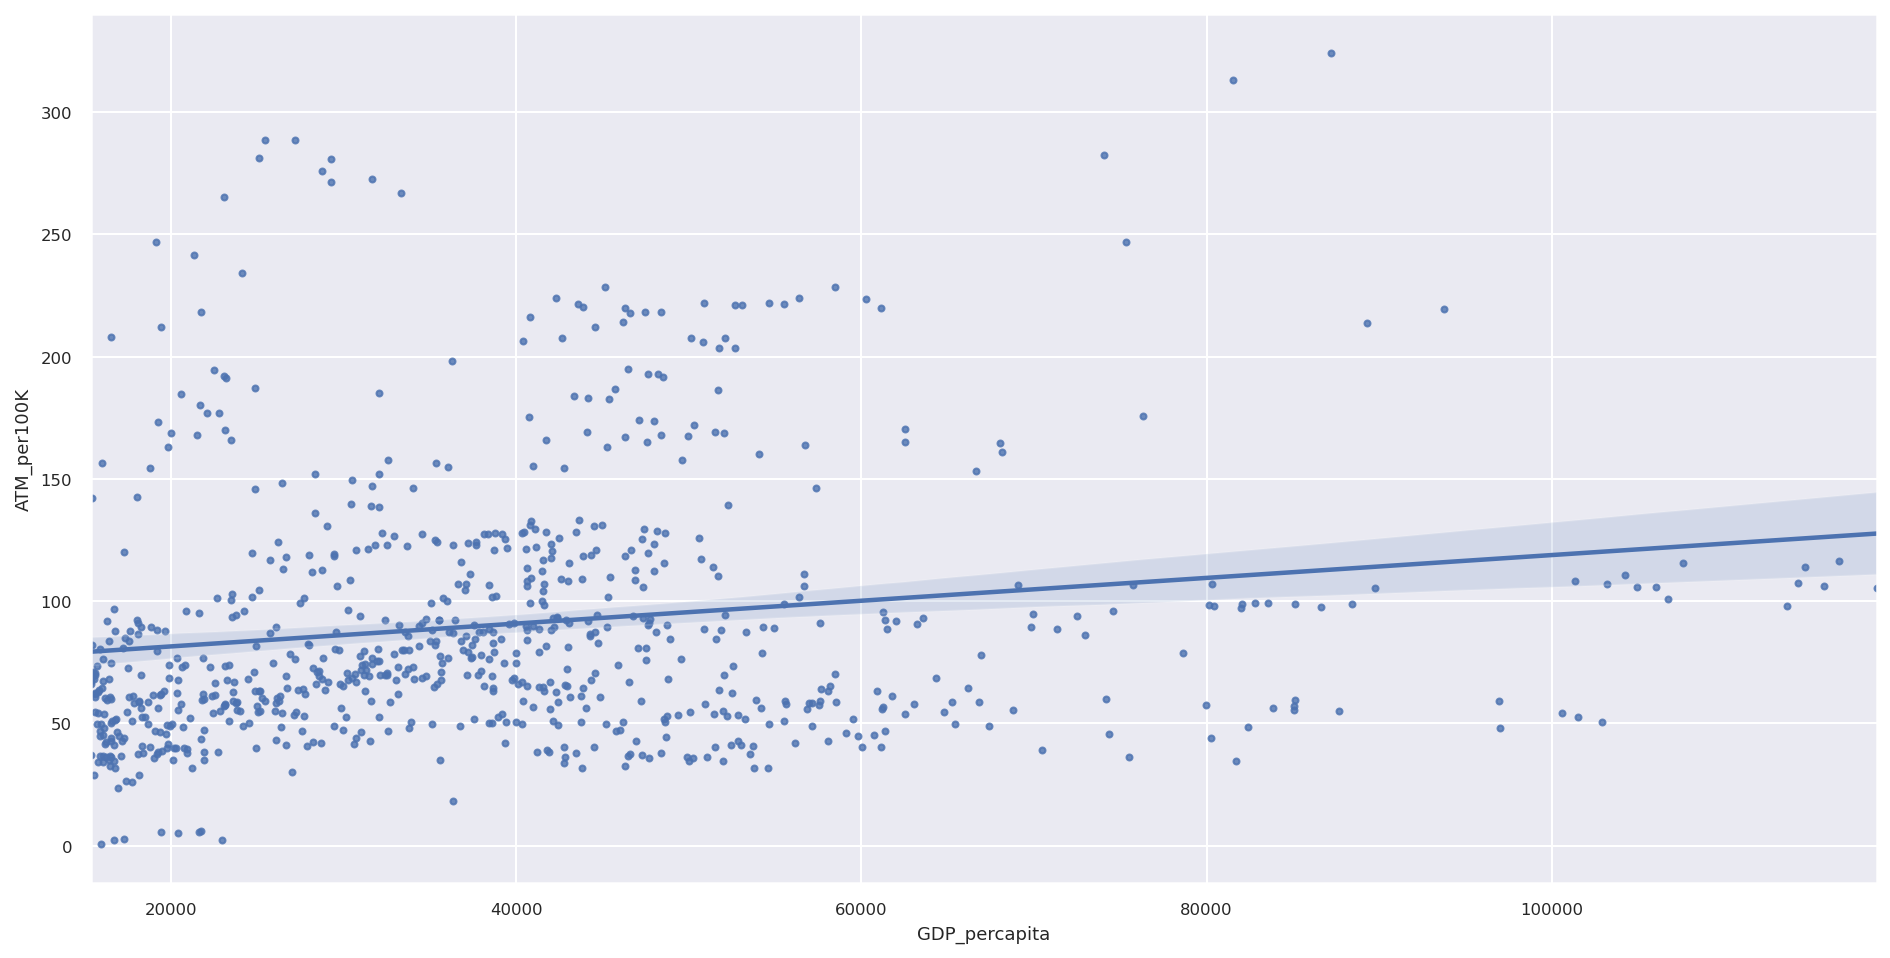

In [32]:
sns.regplot(x='GDP_percapita', y='ATM_per100K', data=df_large, marker = '.')

In [33]:
small_GDP = sm.OLS(df_small['ATM_per100K'], df_small['GDP_percapita']).fit()
small_GDP
small_GDP.params
# results.summary()

GDP_percapita    0.005041
dtype: float64